In [1]:
import cupy as cp
import csv
import numpy as np
import matplotlib.pyplot as plt

 Print out all devices; the first GPU (if present) is typically device 0.

In [2]:
print("Using CuPy version:", cp.__version__)

Using CuPy version: 13.3.0


User-defined dtype (modify this to change precision)

In [3]:
dtype = cp.complex128  # Options: cp.float32, cp.float64, cp.complex64, cp.complex128

Device‐only SVD routine

In [4]:
def batched_svd_gpu(A):
    U_list, S_list, Vh_list = [], [], []
    for i in range(A.shape[0]):
        U, S, Vh = cp.linalg.svd(A[i], full_matrices=False)
        U_list.append(U)
        S_list.append(S)
        Vh_list.append(Vh)
    return cp.stack(U_list), cp.stack(S_list), cp.stack(Vh_list)

Iterate over the batch size

In [5]:
m = 4               # number of rows (fixed)
n = 4               # number of columns (fixed)
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]  # iterate over powers of 2

if dtype in [cp.complex64, cp.complex128]:
  # Determine corresponding real dtype for complex
  real_dtype = np.float32 if dtype == cp.complex64 else np.float64
  real_part = np.random.randn(1, m, n).astype(real_dtype)
  imag_part = np.random.randn(1, m, n).astype(real_dtype)
  batch_cpu = real_part + 1j * imag_part
else:
  batch_cpu = np.random.randn(1, m, n).astype(dtype)

# Move to GPU
batch_gpu = cp.asarray(batch_cpu)

# Time the batched SVD on GPU
U, S, Vh = batched_svd_gpu(batch_gpu)
cp.cuda.Device(0).synchronize()

elapsed_times = []
avg_errors    = []

for B in batch_sizes:
    # Generate random matrices on CPU with specified dtype
    if dtype in [cp.complex64, cp.complex128]:
        # Determine corresponding real dtype for complex
        real_dtype = np.float32 if dtype == cp.complex64 else np.float64
        real_part = np.random.randn(B, m, n).astype(real_dtype)
        imag_part = np.random.randn(B, m, n).astype(real_dtype)
        batch_cpu = real_part + 1j * imag_part
    else:
        batch_cpu = np.random.randn(B, m, n).astype(dtype)

    # Move to GPU
    batch_gpu = cp.asarray(batch_cpu)

    # Time the batched SVD on GPU
    start = cp.cuda.Event()
    end = cp.cuda.Event()
    start.record()
    U, S, Vh = batched_svd_gpu(batch_gpu)
    cp.cuda.Device(0).synchronize()
    end.record()
    end.synchronize()
    elapsed_time = cp.cuda.get_elapsed_time(start, end) / 1000  # ms → s
    elapsed_times.append(elapsed_time)

    # Bring results back to CPU for error check
    U_cpu  = U.get()
    S_cpu  = S.get()
    Vh_cpu = Vh.get()

    # Compute reconstruction errors (all on NumPy now)
    errors = []
    for i in range(B):
        Ai  = batch_cpu[i]             # NumPy array
        Ui  = U_cpu[i]                 # NumPy array
        Si  = np.diag(S_cpu[i])        # NumPy array
        Vhi = Vh_cpu[i]                # NumPy array
        recon_i = Ui @ Si @ Vhi        # NumPy array
        err = 100. * np.linalg.norm(recon_i - Ai) / np.linalg.norm(Ai)
        errors.append(err)

    avg_error = np.mean(errors)
    avg_errors.append(avg_error)

    print(f"Batch size B = {B} → elapsed: {elapsed_time:.6f} s, avg error: {avg_error:.3e}")

Batch size B = 32 → elapsed: 0.474109 s, avg error: 7.020e-14
Batch size B = 64 → elapsed: 0.067961 s, avg error: 6.946e-14
Batch size B = 128 → elapsed: 0.130478 s, avg error: 7.792e-14
Batch size B = 256 → elapsed: 0.254987 s, avg error: 7.803e-14
Batch size B = 512 → elapsed: 0.481876 s, avg error: 7.889e-14
Batch size B = 1024 → elapsed: 1.046674 s, avg error: 7.673e-14
Batch size B = 2048 → elapsed: 2.210930 s, avg error: 7.560e-14
Batch size B = 4096 → elapsed: 2.175402 s, avg error: 7.705e-14
Batch size B = 8192 → elapsed: 4.776417 s, avg error: 7.659e-14


Summary of errors and timings

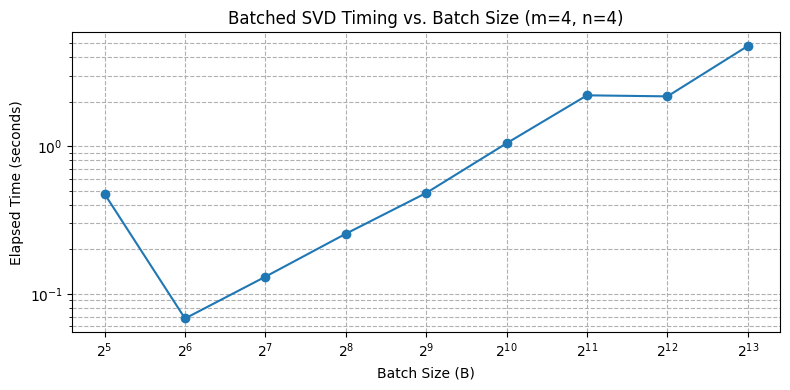

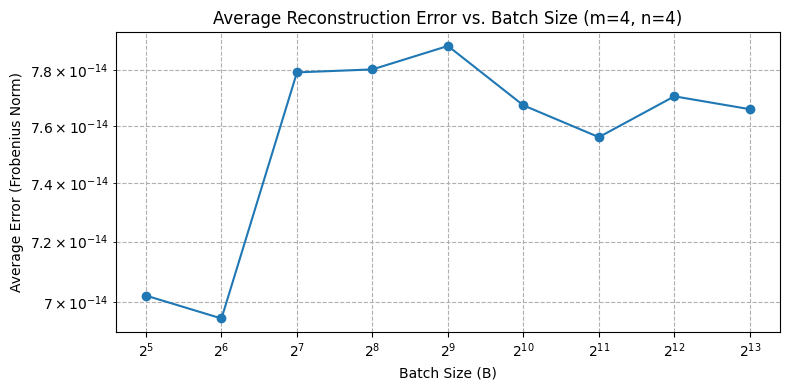

In [6]:
B_array = np.array(batch_sizes)
elapsed_array = np.array(elapsed_times)
error_array = np.array(avg_errors)

# Plot Timing vs. Batch Size (log-log scale)
plt.figure(figsize=(8, 4))
plt.plot(B_array, elapsed_array, marker='o')
plt.title(f"Batched SVD Timing vs. Batch Size (m={m}, n={n})")
plt.xlabel("Batch Size (B)")
plt.ylabel("Elapsed Time (seconds)")
plt.xscale('log', base=2)
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

# Plot Average Reconstruction Error vs. Batch Size (log-log scale)
plt.figure(figsize=(8, 4))
plt.plot(B_array, error_array, marker='o')
plt.title(f"Average Reconstruction Error vs. Batch Size (m={m}, n={n})")
plt.xlabel("Batch Size (B)")
plt.ylabel("Average Error (Frobenius Norm)")
plt.xscale('log', base=2)
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

Saving the results

In [7]:
# Save data to CSV
filename = "resultsCuPy.csv"
with open(filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["elapsed_time", "error"])  # Header row
    writer.writerows(zip(elapsed_times, errors))

print(f"Data saved to {filename}")

Data saved to resultsCuPy.csv
